https://pytorch-forecasting.readthedocs.io/en/latest/tutorials/ar.html

In [6]:
import os
import warnings

warnings.filterwarnings("ignore")

In [7]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
import pandas as pd
import torch

from pytorch_forecasting import Baseline, NBeats, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import SMAPE

# 데이터 불러오기
네트워크의 능력을 보여주기 위해 합성 데이터셋을 생성합니다. 데이터는 이차 트렌드와 계절성 요소로 구성됩니다.

In [69]:
data = generate_ar_data(seasonality=10.0, timesteps=400, n_series=100, seed=42)
data["static"] = 2
data["date"] = pd.Timestamp("2020-01-01") + pd.to_timedelta(data.time_idx, "D")
data.head()

,series,time_idx,value,static,date
0,0,0,-0.000000,2,2020-01-01
1,0,1,-0.046501,2,2020-01-02
2,0,2,-0.097796,2,2020-01-03
3,0,3,-0.144397,2,2020-01-04
4,0,4,-0.177954,2,2020-01-05


훈련을 시작하기 전에 데이터셋을 훈련용과 검증용 시계열 데이터셋으로 나누어야 합니다.

In [9]:
# create dataset and dataloaders
max_encoder_length = 60
max_prediction_length = 20

training_cutoff = data["time_idx"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="value",
    categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
    group_ids=["series"],
    # only unknown variable is "value" - and N-Beats can also not take any additional variables
    time_varying_unknown_reals=["value"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
)

validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

# 기준 성능 측정
우리의 기준 모델은 마지막으로 알려진 값을 반복하여 미래 값을 예측합니다. 결과적으로 SMAPE는 실망스럽고 쉽게 능가할 수 없어야 합니다.

In [10]:
# calculate baseline absolute error
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
SMAPE()(baseline_predictions.to("cpu"), actuals)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


tensor(0.5462)

# 네트워크 훈련
[PyTorch Lightning](https://pytorch-lightning.readthedocs.io/)을 사용하여 최적의 학습 속도를 찾는 것은 쉽습니다. NBeats 모델의 주요 하이퍼파라미터는 너비입니다. 각각은 예측 블록의 너비를 나타냅니다. 기본적으로 첫 번째는 트렌드를 예측하고, 두 번째는 계절성을 예측합니다.

In [11]:
pl.seed_everything(42)
trainer = pl.Trainer(accelerator="auto", gradient_clip_val=0.01)
net = NBeats.from_dataset(training, learning_rate=3e-2, weight_decay=1e-2, widths=[32, 512], backcast_loss_ratio=0.1)

Seed set to 42
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Finding best initial lr: 100%|██████████| 100/100 [00:08<00:00, 11.72it/s]
Learning rate set to 0.004466835921509632
Restoring states from the checkpoint path at /Users/jeanboy/workspace/time-series-ml-app/notebooks/.lr_find_30ca197d-c3e4-400a-8cf3-1c9a3e5704c3.ckpt
Restored all states from the checkpoint at /Users/jeanboy/workspace/time-series-ml-app/notebooks/.lr_find_30ca197d-c3e4-400a-8cf3-1c9a3e5704c3.ckpt


suggested learning rate: 0.004466835921509632


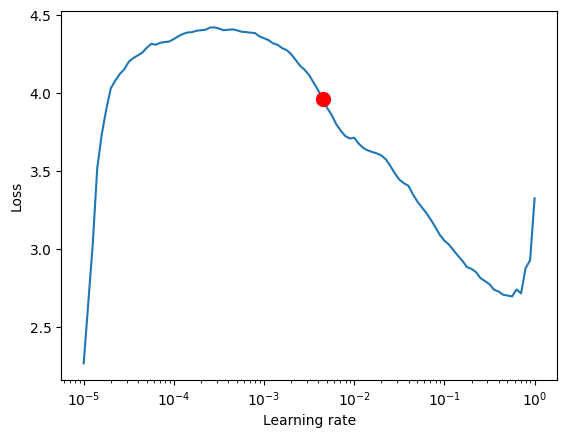

In [12]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    min_lr=1e-5,
    )
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

모델 학습

In [13]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=3,
    accelerator="auto",
    enable_model_summary=True,
    gradient_clip_val=0.01,
    callbacks=[early_stop_callback],
    limit_train_batches=150,
)


net = NBeats.from_dataset(
    training,
    learning_rate=1e-3,
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    widths=[32, 512],
    backcast_loss_ratio=1.0,
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.7 M 
-----------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.851     Total estimated model params size (MB)


Epoch 2: 100%|██████████| 150/150 [00:14<00:00, 10.66it/s, v_num=17, train_loss_step=0.831, val_loss=0.794, train_loss_epoch=0.847]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 150/150 [00:14<00:00, 10.60it/s, v_num=17, train_loss_step=0.831, val_loss=0.794, train_loss_epoch=0.847]


# 결과 평가

In [14]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NBeats.load_from_checkpoint(best_model_path)

검증 데이터셋에 대해 predict()를 사용하여 예측하고, 기준 오차보다 훨씬 낮은 오차를 계산합니다.

In [15]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_model.predict(val_dataloader)
(actuals - predictions.to("cpu")).abs().mean()

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


tensor(0.1852)

검증 세트에서 임의의 샘플을 살펴보는 것은 예측이 합리적인지를 이해하는 데 항상 좋은 방법입니다 - 그리고 그렇습니다!

In [17]:
raw_predictions = best_model.predict(val_dataloader, mode="raw", return_x=True)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [59]:


# validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)
# batch_size = 128

val_dataset = data[lambda x: x.time_idx > training_cutoff]
val_dataset = val_dataset[val_dataset.series==1]

# validation = TimeSeriesDataSet.from_parameters(parameters={
#     "time_idx":"time_idx",
#     "target":"value",
#     "max_encoder_length":max_encoder_length,
#     "max_prediction_length":max_prediction_length,
#     "group_ids":["series"]},
#     data=val_dataset[["time_idx","value","series","date"]])

validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [67]:
best_model.predict_step(batch=[1],batch_idx=[1])

ValueError: not enough values to unpack (expected 2, got 1)

In [70]:
data_1 = data[data.series=="1"]

In [ ]:
validation = TimeSeriesDataSet(
    data[lambda x: x.time_idx > training_cutoff],
    time_idx="time_idx",
    target="value",
    categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
    group_ids=["series"],
    # only unknown variable is "value" - and N-Beats can also not take any additional variables
    time_varying_unknown_reals=["value"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
    min_prediction_idx=training_cutoff + 1
)

validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

{'time_idx': 'time_idx',
 'target': 'value',
 'group_ids': ['series'],
 'weight': None,
 'max_encoder_length': 60,
 'min_encoder_length': 60,
 'min_prediction_idx': 0,
 'min_prediction_length': 20,
 'max_prediction_length': 20,
 'static_categoricals': [],
 'static_reals': [],
 'time_varying_known_categoricals': [],
 'time_varying_known_reals': [],
 'time_varying_unknown_categoricals': [],
 'time_varying_unknown_reals': ['value'],
 'variable_groups': {},
 'constant_fill_strategy': {},
 'allow_missing_timesteps': False,
 'lags': {},
 'add_relative_time_idx': False,
 'add_target_scales': False,
 'add_encoder_length': False,
 'target_normalizer': EncoderNormalizer(
 	method='standard',
 	center=True,
 	max_length=None,
 	transformation=None,
 	method_kwargs={}
 ),
 'categorical_encoders': {'series': NaNLabelEncoder(add_nan=False, warn=True),
  '__group_id__series': NaNLabelEncoder(add_nan=False, warn=True)},
 'scalers': {},
 'randomize_length': None,
 'predict_mode': False}

In [72]:
TimeSeriesDataSet.from_parameters(best_model.dataset_parameters,data, min_prediction_idx=training_cutoff + 1)

TimeSeriesDataSet[length=32100](
	time_idx='time_idx',
	target='value',
	group_ids=['series'],
	weight=None,
	max_encoder_length=60,
	min_encoder_length=60,
	min_prediction_idx=0,
	min_prediction_length=20,
	max_prediction_length=20,
	static_categoricals=[],
	static_reals=[],
	time_varying_known_categoricals=[],
	time_varying_known_reals=[],
	time_varying_unknown_categoricals=[],
	time_varying_unknown_reals=['value'],
	variable_groups={},
	constant_fill_strategy={},
	allow_missing_timesteps=False,
	lags={},
	add_relative_time_idx=False,
	add_target_scales=False,
	add_encoder_length=False,
	target_normalizer=EncoderNormalizer(
	method='standard',
	center=True,
	max_length=None,
	transformation=None,
	method_kwargs={}
),
	categorical_encoders={'series': NaNLabelEncoder(add_nan=False, warn=True), '__group_id__series': NaNLabelEncoder(add_nan=False, warn=True)},
	scalers={},
	randomize_length=None,
	predict_mode=False
)

In [45]:
best_model.predict(data=val_dataloader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


tensor([[ 1.9702e+00,  2.0096e+00,  2.0594e+00,  ...,  2.3862e+00,
          2.3479e+00,  2.2810e+00],
        [ 8.0838e-01,  8.5931e-01,  9.0588e-01,  ...,  1.0178e+00,
          9.8563e-01,  9.6645e-01],
        [ 6.3588e-01,  4.9167e-01,  3.5341e-01,  ...,  3.7988e-01,
          4.7900e-01,  5.0196e-01],
        ...,
        [ 1.6772e+00,  1.6065e+00,  1.5361e+00,  ...,  1.6204e+00,
          1.6729e+00,  1.6659e+00],
        [-1.9942e-02, -4.4509e-03,  1.0592e-02,  ...,  1.8932e-02,
          7.0857e-03,  5.2707e-03],
        [-4.6161e+00, -4.7421e+00, -4.8923e+00,  ..., -5.1906e+00,
         -5.0792e+00, -4.9794e+00]], device='mps:0')

In [ ]:
best_model.ra

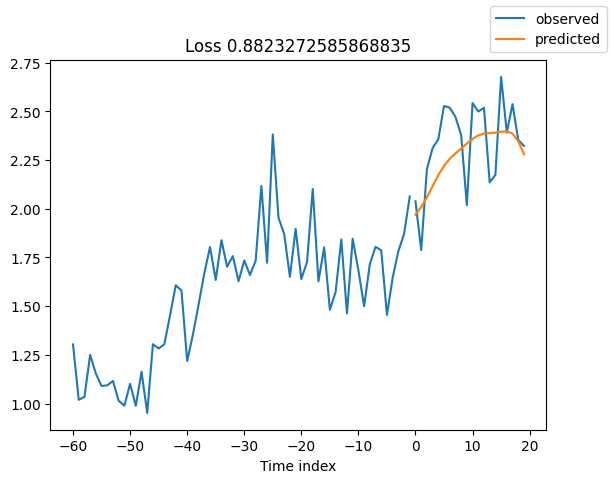

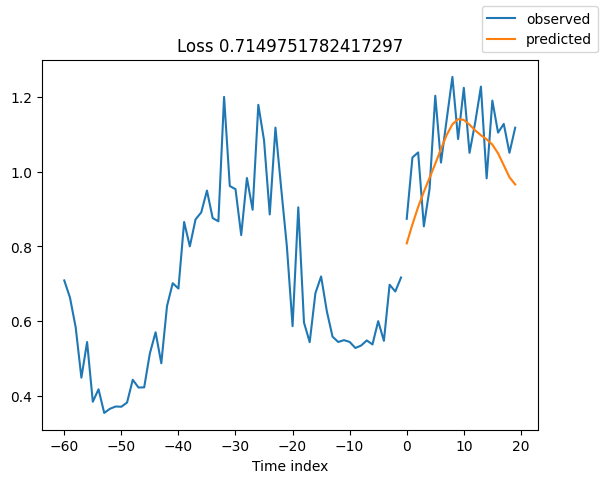

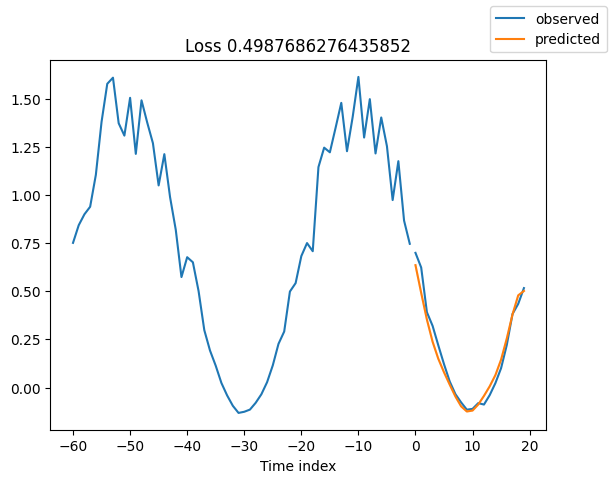

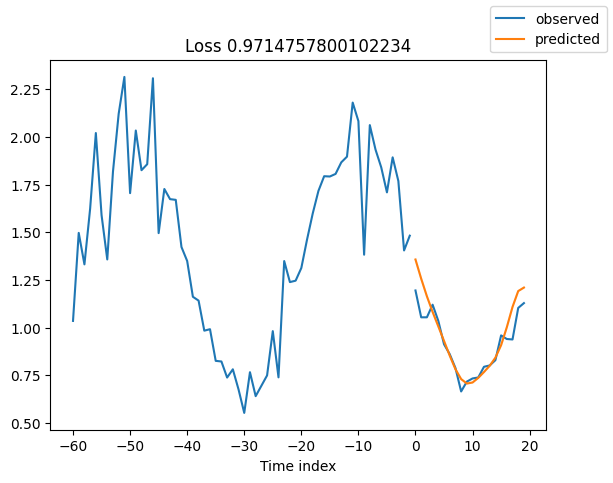

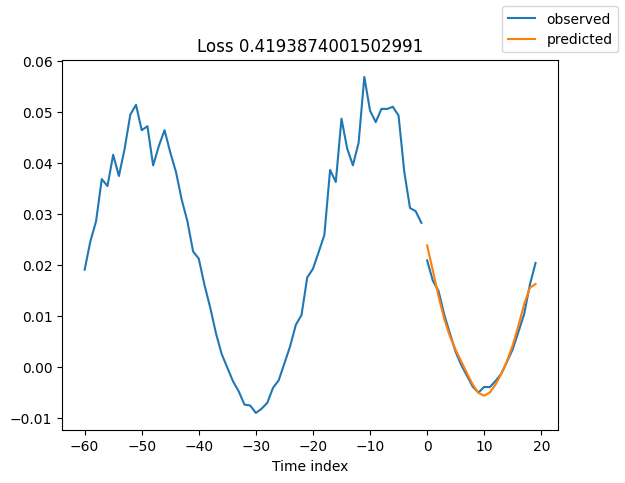

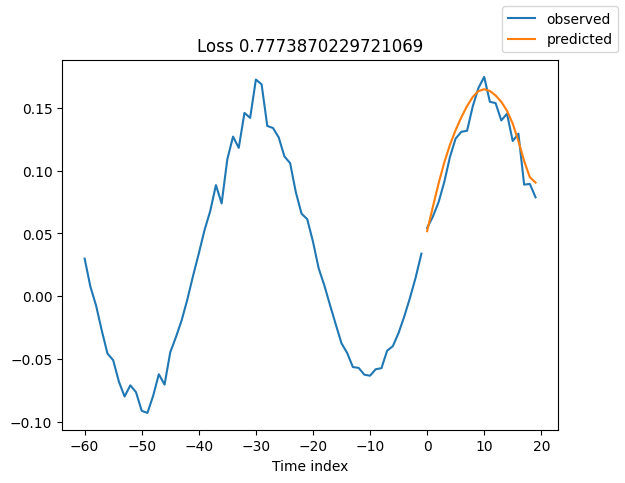

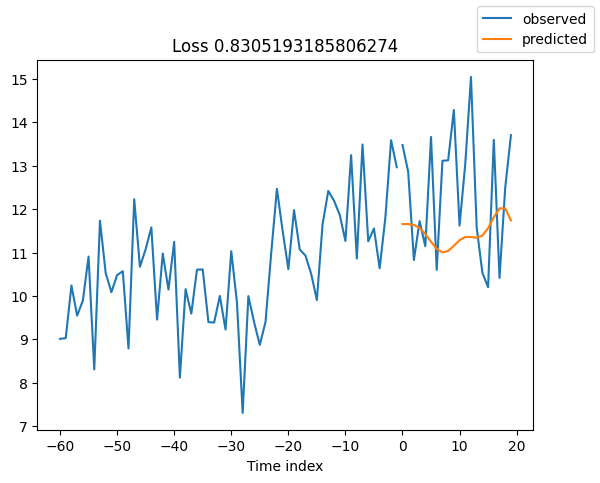

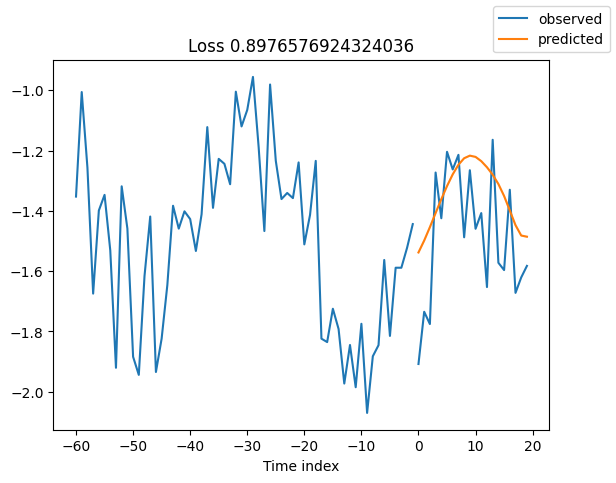

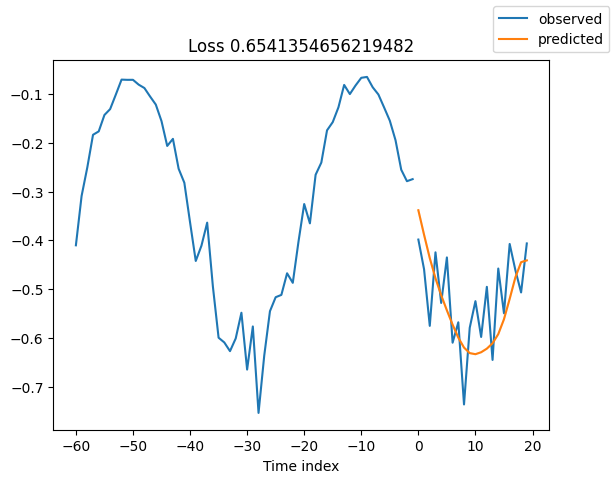

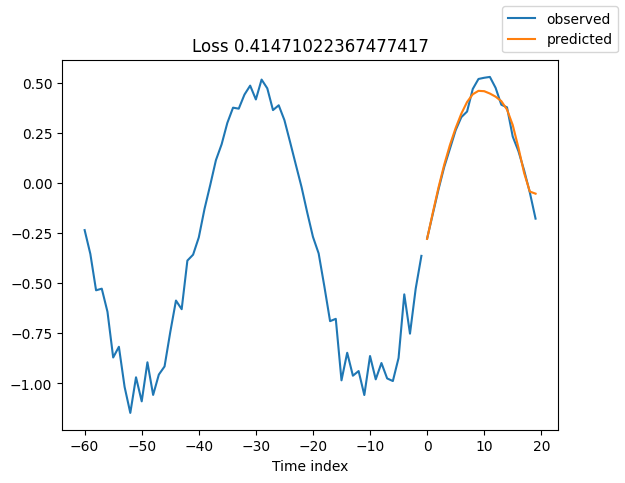

In [15]:
for idx in range(10):  # plot 10 examples
    best_model.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)

# 모델 해석
PyTorch Forecasting에게 plot_interpretation()을 사용하여 예측을 계절성과 트렌드로 분해하도록 요청할 수 있습니다. 이것은 NBeats 모델의 특별한 기능이며, 고유한 아키텍처 덕분에 가능합니다. 결과는 데이터를 설명하는 많은 방법이 있는 것으로 보이며, 알고리즘이 항상 직관적인 의미를 갖는 방법을 선택하지는 않는다는 것을 보여줍니다. 이는 우리가 훈련한 시계열의 수가 적기 때문에 부분적으로 발생합니다(100개). 그러나 우리의 예측 기간이 여러 계절성을 다루지 않기 때문에 발생하기도 합니다.

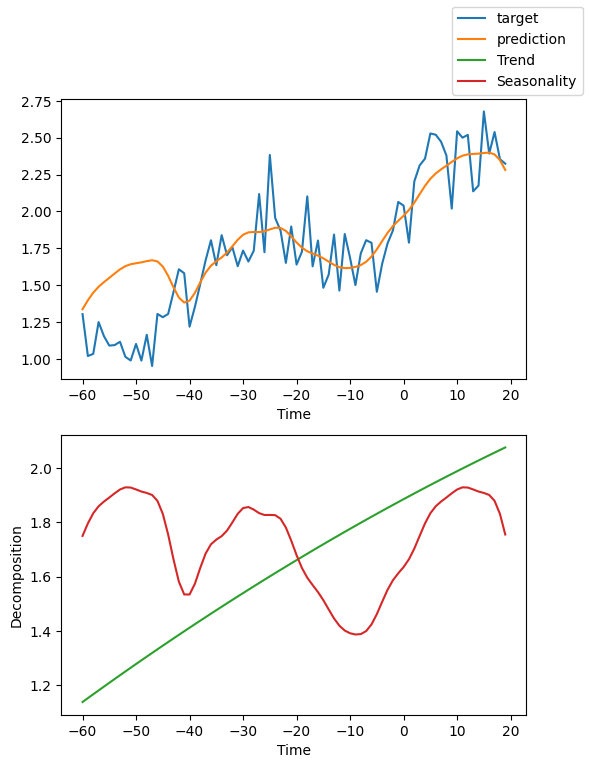

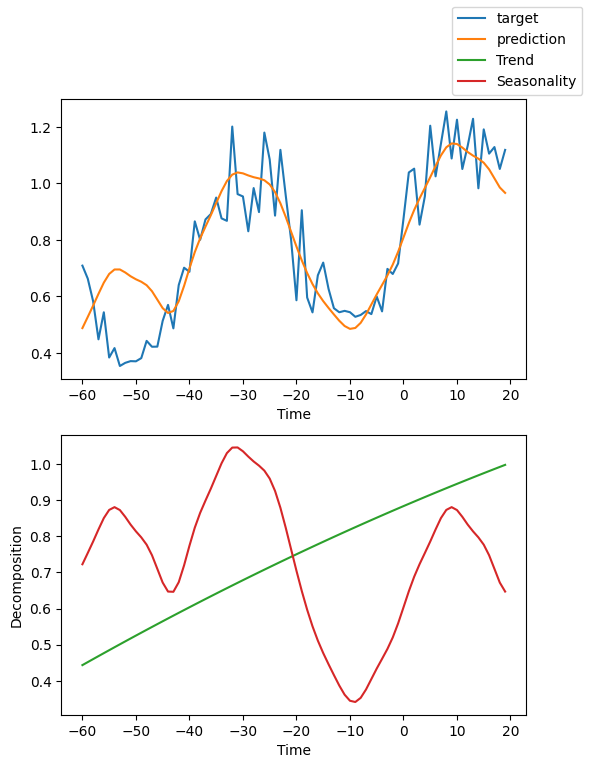

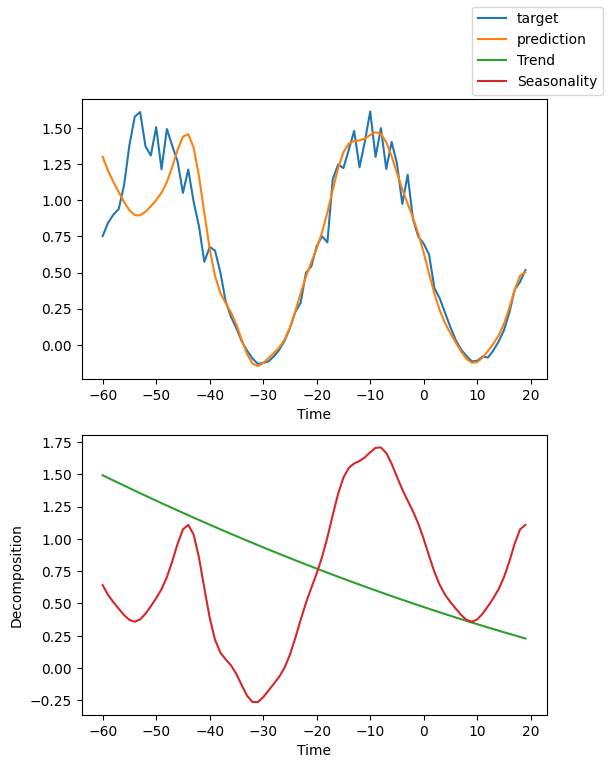

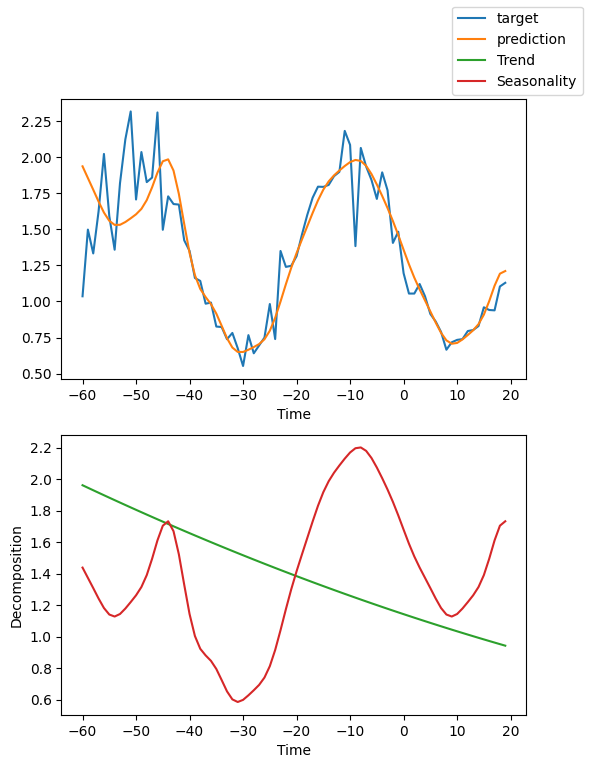

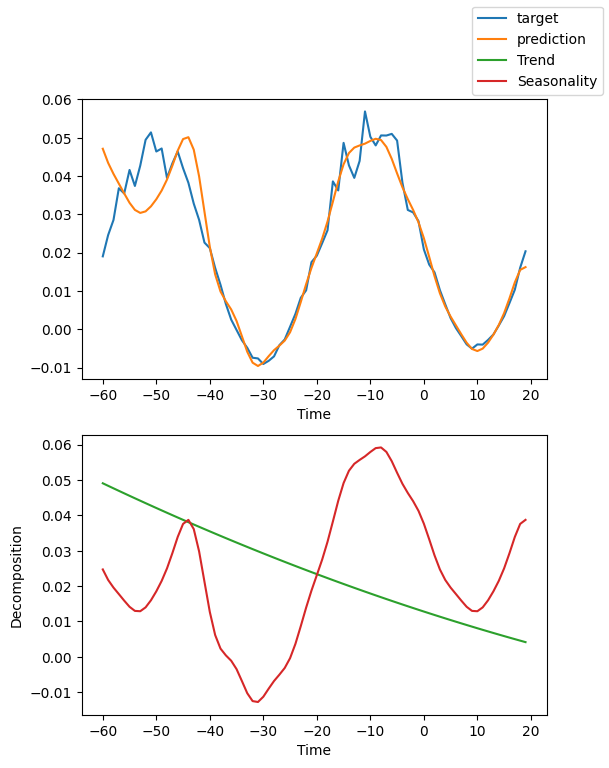

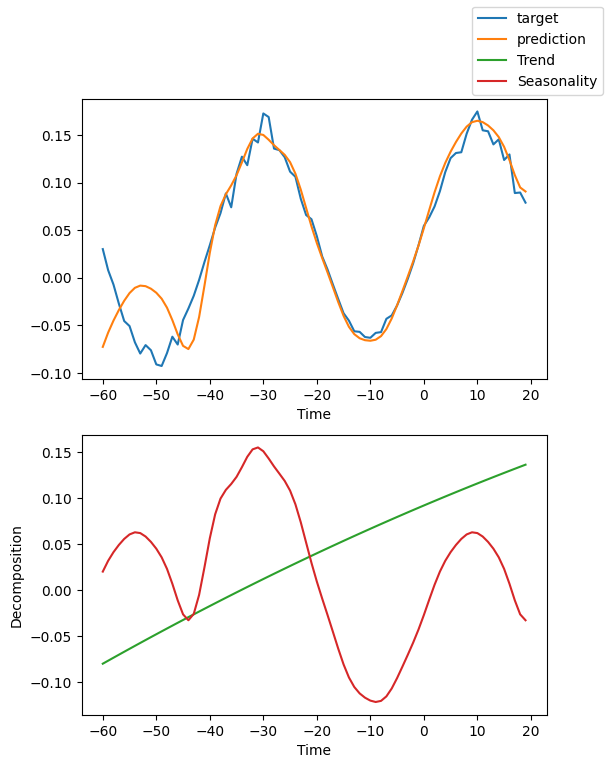

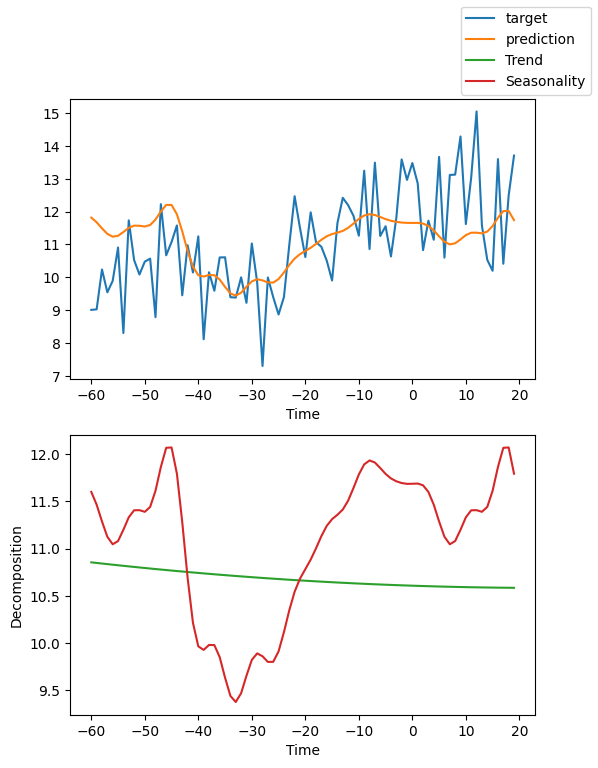

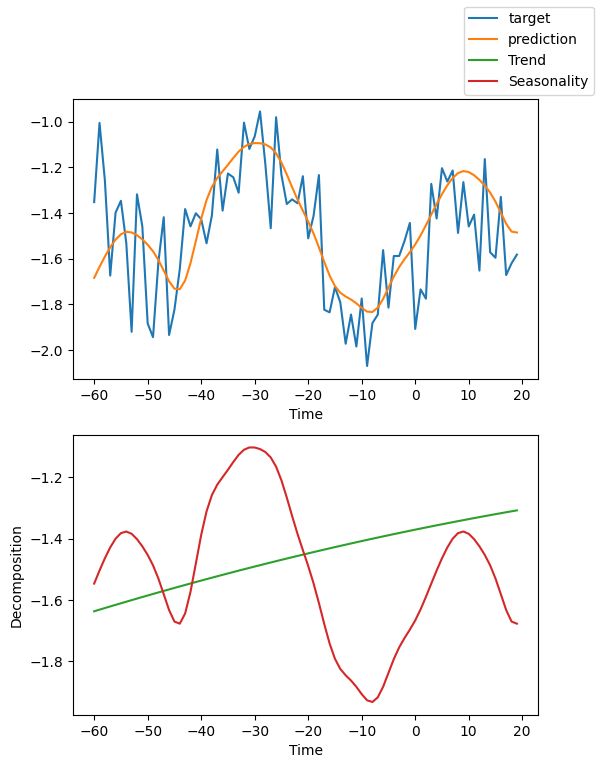

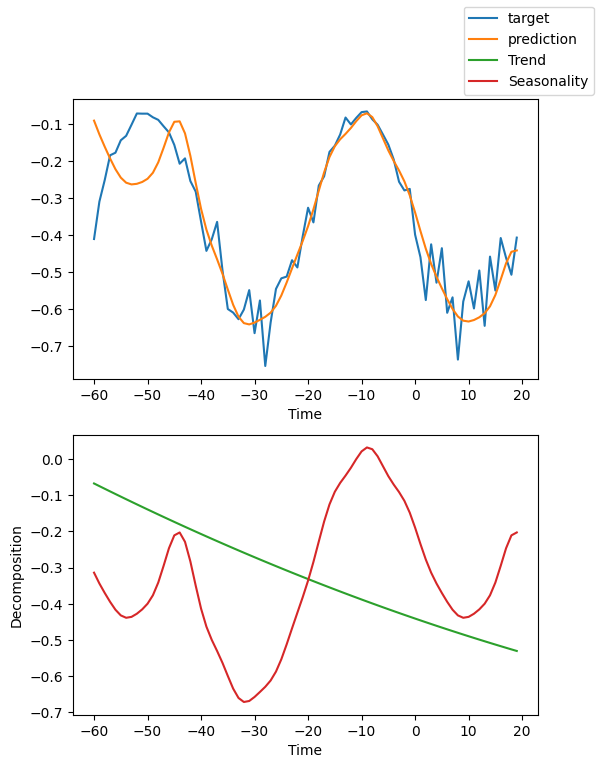

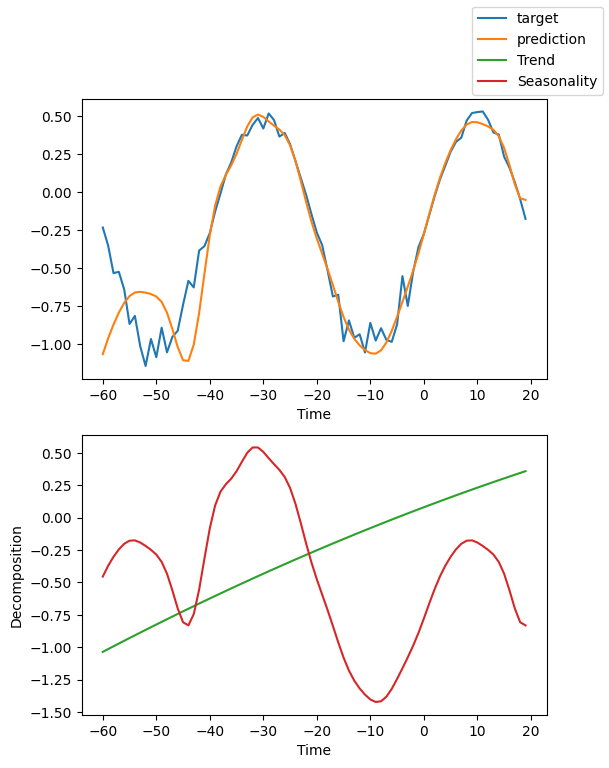

In [16]:
for idx in range(10):  # plot 10 examples
    best_model.plot_interpretation(raw_predictions.x, raw_predictions.output, idx=idx)